In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

sns.set_palette('Accent_r')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [48]:
stock = 'SPY'
factor_list = ['bond_index', 'comm_index', 'stock_index', 'vol_index']

prices = pd.read_csv('data/SPY-prices-20070103-20230804.csv', index_col='Date', parse_dates=True)
volume = pd.read_csv('data/SPY-volume-20070103-20230804.csv', index_col='Date', parse_dates=True)
returns = np.log(prices).diff().fillna(0)

indices = pd.read_csv('data/VTI-AGG-DBC-VIX-prices-20070103-20230804.csv', index_col='Date', parse_dates=True)
prices.rename(columns={'Close': stock}, inplace=True)
returns.rename(columns={'Close': 'returns'}, inplace=True)
indices.rename(columns={index: factor for index, factor in zip(indices.columns, factor_list)}, inplace=True)
prices.head()

,SPY
Date,
2007-01-03,141.369995
2007-01-04,141.669998
2007-01-05,140.539993
2007-01-08,141.190002
2007-01-09,141.070007


In [49]:
stock_specific_factors = volume.copy()
lookback = 60

rolling_vol = returns.rolling(lookback).std() * np.sqrt(252)
exp_ret = returns.rolling(lookback).mean() * 252

stock_specific_factors['rolling_vol'] = rolling_vol
stock_specific_factors['rolling_sharpe'] = exp_ret / rolling_vol
stock_specific_factors['rate_of_change'] = prices.pct_change(lookback)
stock_specific_factors.tail()

,Volume,rolling_vol,rolling_sharpe,rate_of_change
Date,,,,
2023-07-28,80011800,0.106693,4.184715,0.112160
2023-07-31,62040400,0.105155,4.596975,0.121979
2023-08-01,55291500,0.103952,4.821578,0.126749
2023-08-02,93933400,0.103355,3.534778,0.090880
2023-08-03,64276100,0.103708,3.395735,0.087464


In [50]:
factors = pd.merge(stock_specific_factors, indices, on='Date').dropna()

def standard_scale_rolling(df, lookback):
    return (df - df.rolling(lookback).mean()) / df.rolling(lookback).std()

scaled_factors = standard_scale_rolling(factors, lookback).dropna()
scaled_factors.tail()

,Volume,rolling_vol,rolling_sharpe,rate_of_change,bond_index,comm_index,stock_index,vol_index
Date,,,,,,,,
2023-07-28,0.119636,-1.640600,1.476681,1.104967,-0.819258,2.432477,1.614003,-0.970961
2023-07-31,-0.892699,-1.676660,1.736267,1.328338,-0.642525,2.422080,1.642756,-0.790305
2023-08-01,-1.239606,-1.687665,1.869776,1.445199,-1.878331,2.096997,1.521388,-0.614722
2023-08-02,0.977204,-1.667593,0.840518,0.431540,-2.138561,1.486186,1.077323,0.594029
2023-08-03,-0.749609,-1.591192,0.703867,0.307773,-2.831762,1.748701,0.963297,0.513229


In [98]:
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression

returns_ = returns.loc[scaled_factors.index]

linreg = LinearRegression()
params = pd.DataFrame(index=scaled_factors.index, columns=scaled_factors.columns)
params[:] = np.nan

for i in tqdm(range(lookback - 1, len(returns_)), total=len(returns_) - lookback + 1):
    X = scaled_factors.iloc[i - lookback + 1:i + 1]
    y = returns_.iloc[i - lookback + 1:i + 1]
    linreg.fit(X, y)
    params.loc[params.index[i]] = linreg.coef_

params = params.dropna()
params.rename(columns={col: f'{col}_beta' for col in params}, inplace=True)

master_factors = pd.concat([factors, params], axis=1).dropna()
scaled_master_factors = standard_scale_rolling(master_factors, lookback).dropna()
scaled_master_factors.head()

  0%|          | 0/3997 [00:00<?, ?it/s]

,Volume,rolling_vol,rolling_sharpe,rate_of_change,bond_index,comm_index,stock_index,vol_index,Volume_beta,rolling_vol_beta,rolling_sharpe_beta,rate_of_change_beta,bond_index_beta,comm_index_beta,stock_index_beta,vol_index_beta
Date,,,,,,,,,,,,,,,,
2007-12-11,0.660643,2.204285,-0.651264,-0.675200,0.785107,1.157344,-0.636135,0.529004,-0.20945,-0.012158,0.31386,0.008774,-0.055378,-2.473845,-2.155133,-2.906672
2007-12-12,1.535849,1.358583,-1.427689,-1.529260,0.640588,1.676081,-0.392569,0.201810,-0.382264,0.17786,1.020546,-0.988857,-1.854524,-0.872386,-2.461542,-3.151857
2007-12-13,0.469604,1.299259,-1.688936,-1.806126,0.144308,1.403943,-0.371590,0.215739,-0.585977,0.18717,1.287337,-1.342797,-2.754492,-0.711559,-2.780995,-3.361188
2007-12-14,-0.500155,1.389591,-1.824875,-1.954094,-0.228796,1.215510,-0.848859,0.404052,-0.300662,0.088947,1.030106,-1.000258,-1.843284,-1.309337,-2.407862,-2.993906
2007-12-17,-0.283919,1.543536,-2.167885,-2.323610,-0.056392,0.568589,-1.350661,0.733754,-0.108517,0.019691,0.862249,-0.773358,-1.344443,-1.561113,-2.180966,-2.725162


In [104]:
from hmmlearn.hmm import GaussianHMM

markov = GaussianHMM(n_components=3)
markov.fit(scaled_master_factors)
states = markov.decode(scaled_master_factors)[1]

regimes = prices.loc[prices.index[-len(states):]].copy()
regimes['regime'] = states
regimes.head()

,SPY,regime
Date,,
2007-12-11,147.910004,2
2007-12-12,149.369995,2
2007-12-13,149.059998,2
2007-12-14,147.169998,2
2007-12-17,145.070007,2


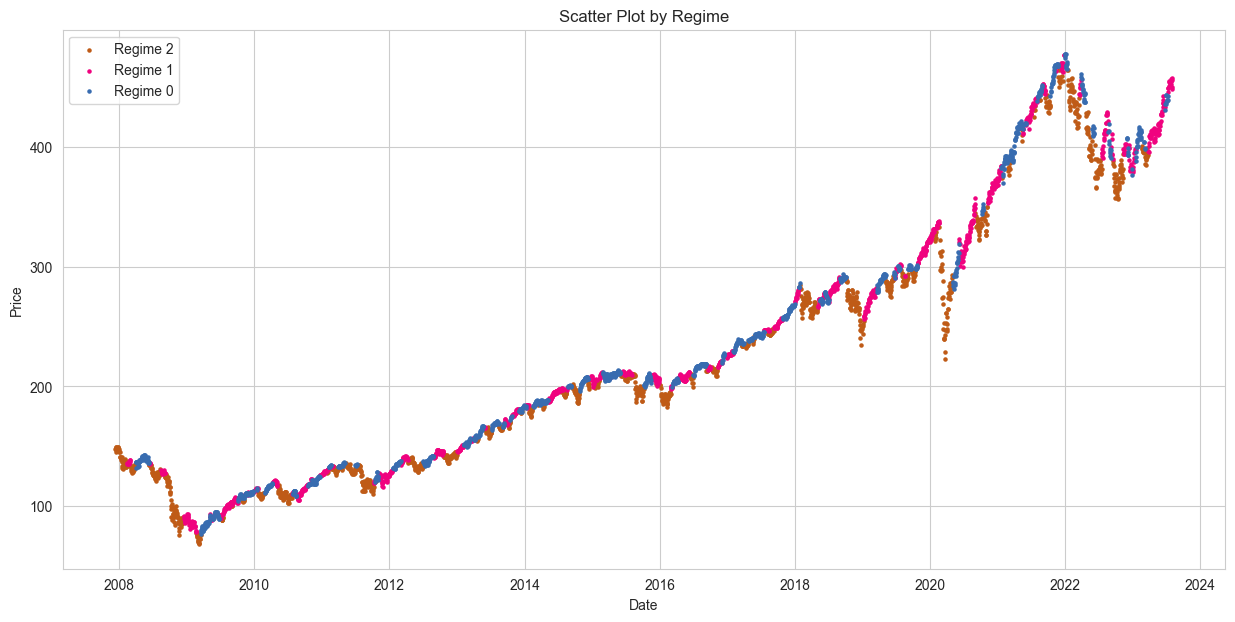

In [118]:
for regime in regimes['regime'].unique():
    subset = regimes[regimes['regime'] == regime]
    plt.scatter(subset.index, subset[stock], label=f'Regime {regime}', s=5)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Scatter Plot by Regime')
plt.legend()
plt.show()

In [128]:
scaled_master_factors_ = scaled_master_factors.loc[scaled_master_factors.index[-len(states):]].copy()
scaled_master_factors_['regime'] = states
scaled_master_factors_.groupby('regime').mean(numeric_only=False)

,Volume,rolling_vol,rolling_sharpe,rate_of_change,bond_index,comm_index,stock_index,vol_index,Volume_beta,rolling_vol_beta,rolling_sharpe_beta,rate_of_change_beta,bond_index_beta,comm_index_beta,stock_index_beta,vol_index_beta
regime,,,,,,,,,,,,,,,,
0,-0.389835,-0.358415,0.590958,0.505993,-0.079188,0.421465,1.250916,-0.753624,-0.029034,-0.266397,-1.007851,0.980917,0.125489,0.155444,0.054440,-0.177866
1,-0.422649,-0.969912,0.902236,0.715228,0.281549,0.349556,1.168450,-0.759793,0.307514,0.116291,1.003379,-1.043245,0.032149,0.038095,0.364544,0.387828
2,0.637314,0.815870,-1.209646,-1.353898,0.086311,-0.467993,-0.800235,1.055729,-0.013638,0.313217,-0.187532,0.184261,-0.279511,-0.114458,-0.266530,-0.305693
